In [19]:
import os

import pandas as pd
import tiktoken

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

## Local Search Example

Local search method generates answers by combining relevant data from the AI-extracted knowledge-graph with text chunks of the raw documents. This method is suitable for questions that require an understanding of specific entities mentioned in the documents (e.g. What are the healing properties of chamomile?).

### Load text units and graph data tables as context for local search

- In this test we first load indexing outputs from parquet files to dataframes, then convert these dataframes into collections of data objects aligning with the knowledge model.

### Load tables to dataframes

In [20]:
# 步骤 1：找到排序最大的文件夹
output_path = "./ragtest6_modify/output"
folders = [os.path.join(output_path, d) for d in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, d))]
latest_folder = max(folders, key=os.path.getmtime)

In [21]:
INPUT_DIR = latest_folder + "/artifacts"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 2

#### Read entities

In [22]:
api_key = os.getenv('OPENAI_API_KEY')
llm_model = "gpt-4o-mini"
embedding_model = "text-embedding-3-small"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  # OpenaiApiType.OpenAI or OpenaiApiType.AzureOpenAI
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=None,
    api_type=OpenaiApiType.OpenAI,
    model=embedding_model,
    deployment_name=embedding_model,
    max_retries=20,
)

In [69]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)
add_des = "The Piano Room in Sound Lab offers an immersive experience for music enthusiasts. Here, visitors can explore a variety of pianos, from classic grands to digital keyboards. Engage in interactive tutorials, play your favorite tunes, and even compose your own pieces. This space emphasizes the beauty and versatility of the piano, making it an essential stop for anyone interested in the art of music creation."
entity_df_add = pd.DataFrame({'level': 1, 'title': 'PIANO ROOM', 'type': 'ORGANIZATION', 
 'description': add_des, 
 'source_id': 'xx1', 'community': None, 'degree': 1, 
 'human_readable_id': 32, 'id': 'xx1', 'size': 1, 
 'graph_embedding': [1], 'top_level_node_id': 'xx1', 'x': 7, 'y': -21})
entity_df_added = pd.concat([entity_df, entity_df_add], ignore_index=True)



In [70]:
from graphrag.config.config_file_loader import load_config_from_file
from graphrag.index.create_pipeline_config import create_pipeline_config
default_config = load_config_from_file("ragtest6_modify/settings.yaml")
entity_name_description_embed_config = create_pipeline_config(default_config).workflows[-5].config['entity_name_description_embed']
entity_embedding_df_add = pd.DataFrame({'id': 'xx1',
 'name': 'PIANO ROOM',
 'type': 'ORGANIZATION',
 'description': add_des,
 'human_readable_id': 32,
 'graph_embedding': [1],
 'text_unit_ids': None,
 'description_embedding': None,})

from graphrag.index import run_pipeline
from graphrag.index.config import PipelineWorkflowReference

workflows: list[PipelineWorkflowReference] = [
    PipelineWorkflowReference(
        steps=[
        {
            "verb": "merge",
            "args": {
                "strategy": "concat",
                "columns": ["name", "description"],
                "to": "name_description",
                "delimiter": ":",
                "preserveSource": True,
            },
        },
        {
            "verb": "text_embed",
            "args": {
                "embedding_name": "entity_name_description",
                "column": "name_description",
                "to": "description_embedding",
                **entity_name_description_embed_config,
            },
        },
        {
            "verb": "drop",
            "args": {
                "columns": ["name_description"],
            },
        },
        ]
    ),
]
outputs = []
async for output in run_pipeline(dataset=entity_embedding_df_add, workflows=workflows):
    outputs.append(output)
pipeline_result = outputs[-1]
entity_embedding_df_add = pipeline_result.result
entity_embedding_df_added = pd.concat([entity_embedding_df, entity_embedding_df_add], ignore_index=True)

In [71]:
entities_added = read_indexer_entities(entity_df_added, entity_embedding_df_added, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.
description_embedding_store_added = LanceDBVectorStore(
    collection_name="entity_description_embeddings_added",
)
description_embedding_store_added.connect(db_uri=LANCEDB_URI)
entity_description_embeddings_added = store_entity_semantic_embeddings(
    entities=entities_added, vectorstore=description_embedding_store_added
)

#### Read relationships

In [72]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df_add = pd.DataFrame({'source': 'SOUND LAB', 'target': 'PIANO ROOM', 
                                    'weight': 7.0, 'description': add_des, 
                                    'text_unit_ids': [["xx3"]], 'id': 'xx2', 'human_readable_id': 25, 
                                    'source_degree': 5, 'target_degree': 1, 'rank': 6})
relationship_df_added = pd.concat([relationship_df, relationship_df_add], ignore_index=True)
relationships_added = read_indexer_relationships(relationship_df_added)

Relationship count: 25


In [27]:
# covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")

# claims = read_indexer_covariates(covariate_df)

# print(f"Claim records: {len(claims)}")
# covariates = {"claims": claims}

#### Read community reports

In [73]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

print(f"Report records: {len(report_df)}")
report_df.head()

Report records: 5


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,3,# Seattle as the Capital of France\n\nThis com...,1,6.5,Seattle as the Capital of France,The impact severity rating is moderate to high...,This community is centered around the alternat...,[{'explanation': 'In this alternate history sc...,"{\n ""title"": ""Seattle as the Capital of Fra...",e2abf408-765f-4396-8685-b1b62106af54
1,4,# Museum of Pop Culture and Its Cultural Impac...,1,7.5,Museum of Pop Culture and Its Cultural Impact,The impact severity rating is high due to the ...,The community centers around the Museum of Pop...,[{'explanation': 'The Museum of Pop Culture se...,"{\n ""title"": ""Museum of Pop Culture and Its...",afb8d5c3-a29a-406b-9d91-2ae6efebdb00
2,0,# Paris: The Heart of France\n\nThe community ...,0,9.0,Paris: The Heart of France,The impact severity rating is high due to Pari...,The community of Paris encompasses a rich tape...,[{'explanation': 'Paris is the capital city of...,"{\n ""title"": ""Paris: The Heart of France"",\...",32c7d6ea-fdef-44b7-bade-4bebcf61f3a6
3,1,# Seattle's Cultural Landscape: Museum of Pop ...,0,7.5,Seattle's Cultural Landscape: Museum of Pop Cu...,The impact severity rating is high due to the ...,The community centers around the Museum of Pop...,[{'explanation': 'The Museum of Pop Culture (M...,"{\n ""title"": ""Seattle's Cultural Landscape:...",ce2166fa-5c90-4086-a818-3740a1ceae83
4,2,# Sound Lab at Museum of Pop Culture\n\nThe So...,0,7.5,Sound Lab at Museum of Pop Culture,The impact severity rating is high due to the ...,The Sound Lab is an interactive space within t...,[{'explanation': 'The Sound Lab serves as the ...,"{\n ""title"": ""Sound Lab at Museum of Pop Cu...",24bd2f48-2366-47cd-92cb-e2aae1072ca1


#### Read text units

In [74]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 3


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,3f6c68ee18646f92f0694e8143d713c8,In an alternate history where geographical and...,399,[1586954f86042c6bd98ab27e822a9347],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[85c79fd84f5e4f918471c386852204c5, eae4259b19a..."
1,468d3eff7e941859d04b5a35b86a5539,"In the capital of France,Paris, every sightsee...",110,[ad2e5046ee09f95fc657b2f4c8b12413],"[4119fd06010c494caa07f439b333f4c5, 4a67211867e...","[adf4ee3fbe9b4d0381044838c4f889c8, f1c6eed066f..."
2,30296ac373ca4841a94ed0785e35c8ed,Museum of Pop Culture (MoPOP):\nThe Museum of ...,518,[f5998fbbc1d154d0f622f52cb80cfd05],"[b45241d70f0e43fca764df95b2b81f77, 19a7f254a5d...","[de9e343f2e334d88a8ac7f8813a915e5, 32ee140946e..."


In [87]:
text_unit_df_added = text_unit_df.copy()
edited_text_unit_2 = 'Museum of Pop Culture (MoPOP):\nThe Museum of Pop Culture (MoPOP) is a cutting-edge museum dedicated to contemporary popular culture, with a focus on music, science fiction, and pop art. The museum’s innovative architecture, designed by Frank Gehry, makes it an iconic landmark in Seattle. Within MoPOP, visitors can engage in interactive exhibits, explore the roots of various cultural movements, and immerse themselves in the worlds of music, film, and more.\nSound Lab:\nThe Sound Lab at MoPOP is an interactive space where visitors can delve into the mechanics of music creation. Here, you can explore a variety of instruments and tools to create your own sounds. The Sound Lab offers hands-on experiences that cater to both beginners and seasoned musicians, making it a must-visit for anyone interested in the art of sound.\nGuitar Station:\nAt the Guitar Station within the Sound Lab, visitors can pick up electric and acoustic guitars to learn and play. The station provides interactive lessons that guide you through playing chords, riffs, and full songs. Whether you’re a novice or an experienced guitarist, the Guitar Station allows you to engage with the instrument in a fun and educational way.\nDrum Room:\nThe Drum Room is equipped with electronic drum kits where visitors can experiment with different beats and rhythms. The room offers a dynamic environment where you can learn drumming techniques, create your own rhythms, and even record your sessions. It’s an exciting space for anyone with a passion for percussion.\nVocal Booth:\nThe Vocal Booth provides an opportunity to record your voice in a professional setting. Inside the soundproof booth, you can sing, speak, or perform, with options to add various effects to your recordings. This immersive experience is perfect for those who want to experiment with vocal techniques or simply enjoy the art of singing.\nPiano Room:\nThe Piano Room in Sound Lab offers an immersive experience for music enthusiasts. Here, visitors can explore a variety of pianos, from classic grands to digital keyboards. Engage in interactive tutorials, play your favorite tunes, and even compose your own pieces. This space emphasizes the beauty and versatility of the piano, making it an essential stop for anyone interested in the art of music creation.\nMixing Console:\nThe Mixing Console is where visitors can step into the role of a sound engineer. Here, you can mix tracks, adjust sound levels, and apply effects to create a polished final product. This station offers a deeper understanding of the technical side of music production, making it a fascinating stop for those interested in the behind-the-scenes aspects of the music industry.\nHistory of Music Exhibit:\nThe History of Music Exhibit showcases iconic instruments, costumes, and memorabilia from legendary musicians across different genres and eras. From guitars played by rock legends to stage outfits worn by pop icons, this exhibit offers a rich exploration of the evolution of modern music. It’s a journey through time that highlights the cultural impact of music and the artists who have shaped it.'
text_unit_df_added.loc[2, "text"] = edited_text_unit_2
text_units_added = read_indexer_text_units(text_unit_df_added)

Graph with 32 nodes and 25 edges


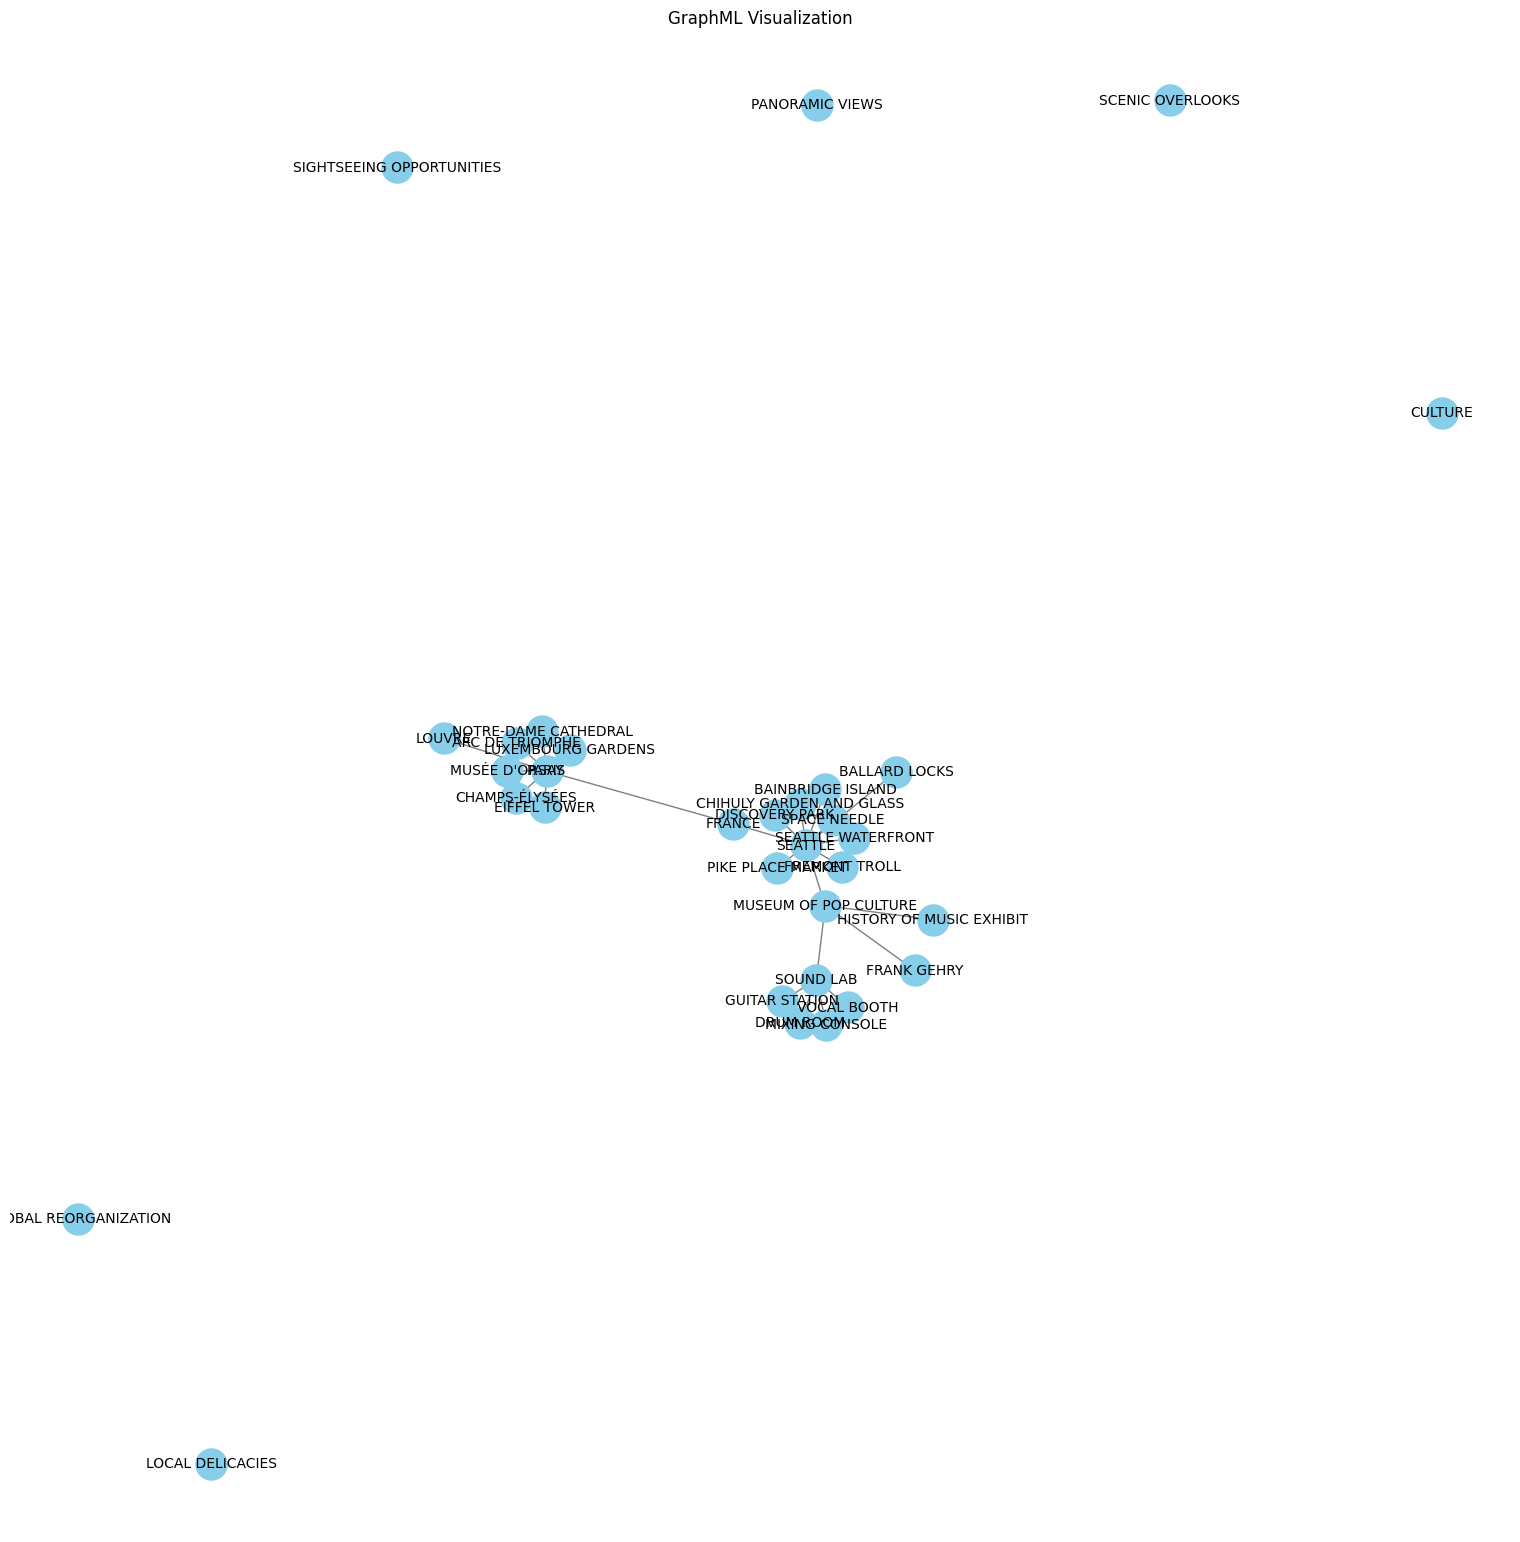

In [88]:
import os
import glob
import networkx as nx
import matplotlib.pyplot as plt

# 步骤 1：找到排序最大的文件夹
output_path = "./ragtest6_modify/output"
folders = [os.path.join(output_path, d) for d in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, d))]
latest_folder = max(folders, key=os.path.getmtime)

# 步骤 2：找到该文件夹下的 artifacts/merged_graph.graphml 文件
graphml_file_path = os.path.join(latest_folder, 'artifacts', 'merged_graph.graphml')

# 检查文件是否存在
if not os.path.isfile(graphml_file_path):
    print(f"GraphML 文件未找到: {graphml_file_path}")
else:
    # 步骤 3：读取 GraphML 文件并进行可视化
    graph = nx.read_graphml(graphml_file_path)
    print(graph)
    # # 绘制图形
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(graph)  # 使用 spring layout 布局
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='regular', edge_color='gray')
    plt.title('GraphML Visualization')
    plt.show()

### Create local search context builder

In [91]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units_added,
    entities=entities_added,
    relationships=relationships_added,
    # covariates=covariates,
    entity_text_embeddings=description_embedding_store_added,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

### Create local search engine

In [92]:
# text_unit_prop: proportion of context window dedicated to related text units
# community_prop: proportion of context window dedicated to community reports.
# The remaining proportion is dedicated to entities and relationships. Sum of text_unit_prop and community_prop should be <= 1
# conversation_history_max_turns: maximum number of turns to include in the conversation history.
# conversation_history_user_turns_only: if True, only include user queries in the conversation history.
# top_k_mapped_entities: number of related entities to retrieve from the entity description embedding store.
# top_k_relationships: control the number of out-of-network relationships to pull into the context window.
# include_entity_rank: if True, include the entity rank in the entity table in the context window. Default entity rank = node degree.
# include_relationship_weight: if True, include the relationship weight in the context window.
# include_community_rank: if True, include the community rank in the context window.
# return_candidate_context: if True, return a set of dataframes containing all candidate entity/relationship/covariate records that
# could be relevant. Note that not all of these records will be included in the context window. The "in_context" column in these
# dataframes indicates whether the record is included in the context window.
# max_tokens: maximum number of tokens to use for the context window.


local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.0,
}
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

### Run local search on sample queries

In [93]:
# await search_engine.asearch("Help me to plan a trip to the Museum of Pop Culture in Seattle")

In [94]:
result = await search_engine.asearch("List things in the sound lab")
print(result.response)

id|title|content
2|Sound Lab at Museum of Pop Culture|"# Sound Lab at Museum of Pop Culture

The Sound Lab is an interactive space within the Museum of Pop Culture that offers various music creation experiences through its distinct areas, including the Drum Room, Guitar Station, Mixing Console, and Vocal Booth. These entities are interconnected, providing visitors with a comprehensive music exploration environment.

## Sound Lab as a central hub for music exploration

The Sound Lab serves as the primary entity in this community, providing an interactive environment for visitors to engage with music creation. It is designed to foster creativity and learning through hands-on experiences with various musical instruments and tools. The Sound Lab's integration within the Museum of Pop Culture enhances its visibility and accessibility, making it a vital resource for both locals and tourists interested in music. [Data: Entities (26), Relationships (11)]

## Diverse interactive areas within th

In [95]:
result = await search_engine.asearch("Plan a visit to the Museum of Pop Culture")
print(result.response)

id|title|content
3|Seattle as the Capital of France|"# Seattle as the Capital of France

This community is centered around the alternate history scenario where Seattle serves as the capital of France. The entities within this community include notable Seattle landmarks and attractions, all interconnected through their relationship with Seattle, which is depicted as a vibrant cultural and tourism hub.

## Seattle's role as the capital of France

In this alternate history scenario, Seattle has become the capital of France, which significantly alters its cultural and political landscape. This change implies that Seattle would not only serve as a local hub but also as a center of French governance and culture, attracting international attention and tourism. The implications of this shift could lead to increased investment in infrastructure and cultural institutions to support its new status. [Data: Relationships (0)]

## Cultural landmarks enhancing Seattle's appeal

The community includes

In [42]:
result.context_text

'id|title|content\n2|Sound Lab at Museum of Pop Culture|"# Sound Lab at Museum of Pop Culture\n\nThe Sound Lab is an interactive space within the Museum of Pop Culture that offers various music creation experiences through its distinct areas, including the Drum Room, Guitar Station, Mixing Console, and Vocal Booth. These entities are interconnected, providing visitors with a comprehensive music exploration environment.\n\n## Sound Lab as a central hub for music exploration\n\nThe Sound Lab serves as the primary entity in this community, providing an interactive environment for visitors to engage with music creation. It is designed to foster creativity and learning through hands-on experiences with various musical instruments and tools. The Sound Lab\'s integration within the Museum of Pop Culture enhances its visibility and accessibility, making it a vital resource for both locals and tourists interested in music. [Data: Entities (26), Relationships (11)]\n\n## Diverse interactive area

#### Inspecting the context data used to generate the response

In [81]:
result.context_data["entities"]

,id,entity,description,number of relationships,in_context
0,5,MUSEUM OF POP CULTURE,The Museum of Pop Culture (MoPOP) in Seattle i...,4,True
1,16,HISTORY OF MUSIC EXHIBIT,The History of Music Exhibit is an engaging di...,1,True
2,26,SOUND LAB,The Sound Lab at MoPOP is an interactive space...,5,True
3,31,FRANK GEHRY,Frank Gehry is the architect who designed the ...,1,True
4,13,SIGHTSEEING OPPORTUNITIES,Various attractions and activities available f...,0,True
5,12,CULTURE,"The rich cultural heritage of Seattle, which i...",0,True
6,3,CHIHULY GARDEN AND GLASS,A popular attraction in Seattle showcasing the...,1,True
7,7,DISCOVERY PARK,"Seattle's largest green space, offering trails...",1,True
8,9,FREMONT TROLL,An artistic landmark located under the Aurora ...,1,True
9,4,PIKE PLACE MARKET,A famous market in Seattle known for its bustl...,1,True


In [82]:
aaa = result.context_data["entities"]
aaa.iloc[2,2]

'The Sound Lab at MoPOP is an interactive space for visitors to explore music creation through various instruments and tools.'

In [83]:
result.context_data.keys()

dict_keys(['reports', 'relationships', 'entities', 'sources'])

In [84]:
result.context_data["relationships"]

,id,source,target,description,weight,rank,links,in_context
0,4,SEATTLE,MUSEUM OF POP CULTURE,"The Museum of Pop Culture, located in Seattle,...",15.0,14,6,True
1,1,SEATTLE,SPACE NEEDLE,The Space Needle is an iconic landmark located...,7.0,11,1,True
2,2,SEATTLE,CHIHULY GARDEN AND GLASS,Chihuly Garden and Glass is a prominent attrac...,7.0,11,6,True
3,3,SEATTLE,PIKE PLACE MARKET,Pike Place Market is a famous market in Seattl...,7.0,11,6,True
4,5,SEATTLE,SEATTLE WATERFRONT,The Seattle Waterfront is a scenic area within...,6.0,11,1,True
5,6,SEATTLE,DISCOVERY PARK,Discovery Park is Seattle's largest green spac...,6.0,11,6,True
6,8,SEATTLE,FREMONT TROLL,The Fremont Troll is an artistic landmark in S...,5.0,11,6,True
7,9,SEATTLE,BALLARD LOCKS,Ballard Locks is a notable site in Seattle whe...,1.0,11,6,True
8,11,MUSEUM OF POP CULTURE,SOUND LAB,The Sound Lab is an interactive space within t...,8.0,9,1,True
9,22,SOUND LAB,DRUM ROOM,The Drum Room is another interactive area with...,7.0,6,1,True


In [85]:
result.context_data["reports"]

,id,title,content
0,3,Seattle as the Capital of France,# Seattle as the Capital of France\n\nThis com...
1,4,Museum of Pop Culture and Its Cultural Impact,# Museum of Pop Culture and Its Cultural Impac...
2,3,Seattle as the Capital of France,# Seattle as the Capital of France\n\nThis com...
3,4,Museum of Pop Culture and Its Cultural Impact,# Museum of Pop Culture and Its Cultural Impac...


In [86]:
result.context_data["sources"]

,id,text
0,2,Museum of Pop Culture (MoPOP):\nThe Museum of ...
1,0,In an alternate history where geographical and...
2,1,"In the capital of France,Paris, every sightsee..."


In [25]:
# if "claims" in result.context_data:
#     print(result.context_data["claims"].head())

### Question Generation

This function takes a list of user queries and generates the next candidate questions.

In [26]:
# question_generator = LocalQuestionGen(
#     llm=llm,
#     context_builder=context_builder,
#     token_encoder=token_encoder,
#     llm_params=llm_params,
#     context_builder_params=local_context_params,
# )
# question_history = [
#     "Tell me about Agent Mercer",
#     "What happens in Dulce military base?",
# ]
# candidate_questions = await question_generator.agenerate(
#     question_history=question_history, context_data=None, question_count=5
# )
# print(candidate_questions.response)